In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(cv2.__version__)

3.4.1


In [3]:
image = cv2.imread('formImage.jpg')

In [4]:
def removePadding(image):
    up = 0
    down = 0
    left = 0
    right = 0
    while sum(image[:,0] == 0) > 0.95*image.shape[0] or sum(image[:,0] == 255) > 0.95*image.shape[0]:
        image = image[:,1:]
        up += 1
    while sum(image[0,:] == 0) > 0.95*image.shape[1] or sum(image[0,:] == 255) > 0.95*image.shape[1]:
        image = image[1:,:]
        left += 1
    while sum(image[:,-1] == 0) > 0.95*image.shape[0] or sum(image[:,-1] == 255) > 0.95*image.shape[0]:
        image = image[:,:-1]
        right += 1
    while sum(image[-1,:] == 0) > 0.95*image.shape[1] or sum(image[-1,:] == 255) > 0.95*image.shape[1]:
        image = image[:-1,:]
        down += 1
    print('Number of lines removed-\nUp = {}\nLeft = {}\nRight = {}\nDown = {}'.format(up, left, right, down))
    return image

In [39]:
def removePadding2(image):
    while sum(image[:,0] == 0) == image.shape[0] or sum(image[:,0] == 255) == image.shape[0]:
        image = image[:,1:]
    while sum(image[0,:] == 0) == image.shape[1] or sum(image[0,:] == 255) == image.shape[1]:
        image = image[1:,:]
    while sum(image[:,-1] == 0) == image.shape[0] or sum(image[:,-1] == 255) == image.shape[0]:
        image = image[:,:-1]
    while sum(image[-1,:] == 0) == image.shape[1] or sum(image[-1,:] == 255) == image.shape[1]:
        image = image[:-1,:]
    return image

In [30]:
def removeBoxes(image, threshX = 60, threshY = 40):
    for i in range(image.shape[0]):
        """if sum(image[i, :] == 0) >= threshX:
            image[i, :] = 255"""
        countBlack = 0
        for j in range(image.shape[1]):
            if image[i,j] == 0:
                countBlack += 1
            else:
                if countBlack >= threshX:
                    image[i,j-countBlack:j] = 255
                countBlack = 0
                
    for i in range(image.shape[1]):
        if sum(image[:,i] == 0) >= threshY:
            image[:,i] = 255
            
        """countBlack = 0
        for j in range(image.shape[0]):
            if image[j,i] == 0:
                countBlack += 1
            else:
                if countBlack >= threshY:
                    image[:,i] = 255
                    print('Vertical line Deleted')
                #countBlack = 0"""
                
    return image
    

In [24]:
def postRemoveProcessing(image):
    image = cv2.medianBlur(image,3)
    image = cv2.dilate(image, cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)))
    image = cv2.erode(image, cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)))
    return image

In [62]:
def modifiedRemoveBoxes(image, threshX = 50, threshY = 30):
    for i in range(image.shape[0]):
        countBlack = 0
        for j in range(image.shape[1]):
            if image[i,j] == 0:
                countBlack += 1
            else:
                if countBlack >= threshX:
                    image[i,j-countBlack:j] = 255
                countBlack = 0
                
    for i in range(image.shape[1]):
        countBlack = 0
        for j in range(image.shape[0]):
            if image[j,i] == 0:
                countBlack += 1
            else:
                if countBlack >= threshY:
                    image[j-countBlack:j,i] = 255
                countBlack = 0
    return image

In [8]:
def getBoundaries(image, threshold=60):
    boundaryRows = []
    for i in range(image.shape[0]):
        blackCount = 0
        for j in range(image.shape[1]):
            if image[i,j] == 0:
                blackCount += 1
            elif blackCount > threshold:
                boundaryRows.append(i)
                break
            else:
                blackCount = 0
    print('Total Number of boundaries detected = ', len(boundaryRows))
    return boundaryRows

In [58]:
def segmentCharacters(image, threshold=10):
    image = removePadding2(image)
    prev = 0
    image[:,0] = 128
    for i in range(1, image.shape[1]):
        if (image[:,i] == 255).all() and (i-prev) > threshold:
            image[:,i] = 128
            prev = i
    return image

In [9]:
#resizedImage = cv2.resize(image, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)

In [10]:
#resizedImage.shape

In [11]:
grayScaleImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [12]:
grayScaleImage.shape

(3507, 2550)

In [13]:
retVal, tempImage = cv2.threshold(grayScaleImage, 0, 255,  cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [14]:
binarizedImage = cv2.medianBlur(tempImage,3)

In [15]:
marginRemovedImage = removePadding(binarizedImage)

Number of lines removed-
Up = 10
Left = 10
Right = 179
Down = 168


In [16]:
cv2.imwrite('./openCvImages/otsuBinarizedImage.jpg', binarizedImage)

True

In [17]:
cv2.imwrite('./openCvImages/marginRemovedImage.jpg', marginRemovedImage)

True

In [18]:
boundaries = getBoundaries(marginRemovedImage, threshold = 200)

Total Number of boundaries detected =  585


In [19]:
# assuming the boundaries of boxes are atleast 40 rows apart

filteredBoundaries = [boundaries[0]]
prev = boundaries[0]
for val in boundaries[1:]:
    if (val - prev) > 40:
        prev = val
        filteredBoundaries.append(val)
print('Number of boundaries = ', len(filteredBoundaries))

Number of boundaries =  42


In [20]:
temp = marginRemovedImage.copy()
temp[filteredBoundaries,:] = 128
cv2.imwrite('./openCvImages/temp.jpg', temp)

True

In [37]:
for i in range(0,len(filteredBoundaries)-1):
    temp = marginRemovedImage[filteredBoundaries[i]:filteredBoundaries[i+1],:].copy()
    temp = removeBoxes(temp, threshX=55, threshY=40)
    processedImage = postRemoveProcessing(temp)
    cv2.imwrite('./openCvImages/lines/{}.jpg'.format(i), processedImage)

threshold = 60 , number of lines detected = 650
threshold = 100, number of lines detected = 628
threshold = 200, number of lines detected = 585
threshold = 500, number of lines detected = 466

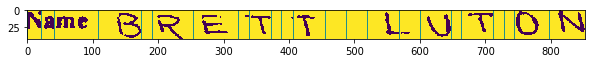

In [60]:
retVal, temp = cv2.threshold(cv2.cvtColor(cv2.imread('./openCvImages/lines/5.jpg'), cv2.COLOR_BGR2GRAY), 128, 255, cv2.THRESH_BINARY)
cv2.medianBlur(temp,3)
plt.figure(figsize=(10,200))
plt.imshow(segmentCharacters(temp, threshold=15))

In [63]:
fullFormImage = binarizedImage.copy()
fullFormImage = modifiedRemoveBoxes(fullFormImage, threshX = 60, threshY=30)
fullFormImage = cv2.medianBlur(fullFormImage,3)
fullFormImage = cv2.dilate(fullFormImage, cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)))
fullFormImage = cv2.erode(fullFormImage, cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)))
cv2.imwrite('./openCvImages/processedImage.jpg', fullFormImage)

True

In [376]:
formNumberImage = binarizedImage[330:450, 200:1000].copy()
formNumberImage = removeBoxes(formNumberImage)
formNumberImage = cv2.medianBlur(formNumberImage,3)

In [379]:
formNumberImage = cv2.dilate(formNumberImage, cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)))
formNumberImage = cv2.erode(formNumberImage, cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)))

In [380]:
cv2.imshow('originalImage',grayScaleImage[330:450, 200:1000])
cv2.imshow('binarizedImage',binarizedImage[330:450, 200:1000])
cv2.imshow('processedBinarizedImage',formNumberImage)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [93]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=None, filternorm=1, filterrad=4.0, imlim=None, resample=None, url=None, hold=None, data=None, **kwargs)
    Display an image on the axes.
    
    Parameters
    ----------
    X : array_like, shape (n, m) or (n, m, 3) or (n, m, 4)
        Display the image in `X` to current axes.  `X` may be an
        array or a PIL image. If `X` is an array, it
        can have the following shapes and types:
    
        - MxN -- values to be mapped (float or int)
        - MxNx3 -- RGB (float or uint8)
        - MxNx4 -- RGBA (float or uint8)
    
        The value for each component of MxNx3 and MxNx4 float arrays
        should be in the range 0.0 to 1.0. MxN arrays are mapped
        to colors based on the `norm` (mapping scalar to scalar)
        and the `cmap` (mapping the normed scalar to a color).
    
    cm

In [86]:
help(cv2.destroyWindow)

Help on built-in function destroyWindow:

destroyWindow(...)
    destroyWindow(winname) -> None
    .   @brief Destroys the specified window.
    .   
    .   The function destroyWindow destroys the window with the given name.
    .   
    .   @param winname Name of the window to be destroyed.



In [11]:
help(cv2.threshold)

Help on built-in function threshold:

threshold(...)
    threshold(src, thresh, maxval, type[, dst]) -> retval, dst
    .   @brief Applies a fixed-level threshold to each array element.
    .   
    .   The function applies fixed-level thresholding to a multiple-channel array. The function is typically
    .   used to get a bi-level (binary) image out of a grayscale image ( #compare could be also used for
    .   this purpose) or for removing a noise, that is, filtering out pixels with too small or too large
    .   values. There are several types of thresholding supported by the function. They are determined by
    .   type parameter.
    .   
    .   Also, the special values #THRESH_OTSU or #THRESH_TRIANGLE may be combined with one of the
    .   above values. In these cases, the function determines the optimal threshold value using the Otsu's
    .   or Triangle algorithm and uses it instead of the specified thresh.
    .   
    .   @note Currently, the Otsu's and Triangle methods a

In [211]:
help(cv2.GaussianBlur)

Help on built-in function GaussianBlur:

GaussianBlur(...)
    GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]]) -> dst
    .   @brief Blurs an image using a Gaussian filter.
    .   
    .   The function convolves the source image with the specified Gaussian kernel. In-place filtering is
    .   supported.
    .   
    .   @param src input image; the image can have any number of channels, which are processed
    .   independently, but the depth should be CV_8U, CV_16U, CV_16S, CV_32F or CV_64F.
    .   @param dst output image of the same size and type as src.
    .   @param ksize Gaussian kernel size. ksize.width and ksize.height can differ but they both must be
    .   positive and odd. Or, they can be zero's and then they are computed from sigma.
    .   @param sigmaX Gaussian kernel standard deviation in X direction.
    .   @param sigmaY Gaussian kernel standard deviation in Y direction; if sigmaY is zero, it is set to be
    .   equal to sigmaX, if both sigmas are z